In [1]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
from sklearn.metrics import (classification_report,confusion_matrix, accuracy_score)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

2026-02-26 08:19:45.132369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772093985.331655      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772093985.393237      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772093985.842345      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772093985.842380      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772093985.842383      55 computation_placer.cc:177] computation placer alr

# Chemins vers les donnees

In [2]:
train_path = '/kaggle/input/datasets/rabieoudghiri/plantvillage-split-70-15-15/plantvillage_split/train'
valid_path = '/kaggle/input/datasets/rabieoudghiri/plantvillage-split-70-15-15/plantvillage_split/valid'
test_path = '/kaggle/input/datasets/rabieoudghiri/plantvillage-split-70-15-15/plantvillage_split/test'

# Generateur TRAIN (avec augmentation)
> L’augmentation cree des variantes des images pour mieux apprendre

In [3]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,# Normalisation DenseNet
    rotation_range=40, # Rotation aleatoire jusqu’a 40 degres
    horizontal_flip=True, # Miroir horizontal (feuille retournee)
    vertical_flip=True,# Miroir vertical (important pour feuilles)
    width_shift_range=0.2,# Decalage horizontal 20%
    height_shift_range=0.2, # Decalage vertical 20%
    zoom_range=0.2,# Zoom in/out 20%
    brightness_range=[0.8, 1.2],# Variation de luminosite
    fill_mode='nearest' # Remplissage des pixels vides
)

# Generateur VALID (sans augmentation)
> On ne modifie PAS les images de validation

In [4]:
valid_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

#  Generateur TEST (sans augmentation, sans melange)

In [5]:
test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

# Creer les batchs

In [6]:
train_batches = train_datagen.flow_from_directory(
    directory = train_path,
    target_size = (224,224),  # Taille requise par DenseNet
    batch_size = 64,
    shuffle = True # Melanger les images a chaque epoch
)

valid_batches = valid_datagen.flow_from_directory(
    directory = valid_path,
    target_size = (224,224),  # Taille requise par DenseNet
    batch_size = 64,
    shuffle = False
)

test_batches = test_datagen.flow_from_directory(
    directory = test_path,
    target_size = (224,224),  # Taille requise par DenseNet
    batch_size = 64,
    shuffle = False
)

Found 37997 images belonging to 38 classes.
Found 8129 images belonging to 38 classes.
Found 8180 images belonging to 38 classes.


# On augmente seulement train parce que:

> L’augmentation sert à aider le modèle à apprendre, Validation et test servent à mesurer objectivement


# Verification

In [7]:
print("Classes detectees :", len(train_batches.class_indices))
print("Images train :", train_batches.samples)
print("Images valid :", valid_batches.samples)
print("Images test :", test_batches.samples)

imgs, labels = next(train_batches)
print("Shape d'un batch :", imgs.shape)
print("Shape des labels :", labels.shape)

Classes detectees : 38
Images train : 37997
Images valid : 8129
Images test : 8180
Shape d'un batch : (64, 224, 224, 3)
Shape des labels : (64, 38)


# Charger DenseNet121 pre-entraine sur ImageNet

In [8]:
base_model = DenseNet121(
    weights = 'imagenet', # Poids pre-entraines sur ImageNet
    include_top = False, # On enleve la tete de classification originale
    input_shape = (224,224,3)
)

I0000 00:00:1772094102.136548      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1772094102.142613      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Geler TOUTES les couches de base (Phase 1)

> On ne veut pas modifier les poids pre-entraines pour l’instant

In [9]:
base_model.trainable = False

print(f"Couches dans DenseNet121 : {len(base_model.layers)}")
print(f"Couches entrainables :{sum (l for l in base_model.layers if l.trainable)}")

Couches dans DenseNet121 : 427
Couches entrainables :0


#  Construire le modele complet

In [10]:
model_121 = Sequential([
    base_model, # Corps DenseNet121 (gele)
    GlobalAveragePooling2D(), #  Reduit les features en vecteur
    BatchNormalization(), # Stabilise l'apprentissage
    Dense(512, activation='relu'), # Couche Dense 1
    Dropout(0.5), # Evite l’overfitting (50%)
    Dense(256, activation='relu'), # Couche Dense 1
    Dropout(0.3),  # Evite l’overfitting (50%)
    Dense(38, activation='softmax') #Sortie : 38 probabilites
])



## Architecture du modèle DenseNet121 (Transfer Learning)

Ce modèle utilise DenseNet121 pré-entraîné sur ImageNet comme extracteur de caractéristiques, avec une nouvelle tête de classification adaptée à notre dataset (38 classes).

### 🔹 Structure du modèle :

1. **Base Model : DenseNet121 (include_top=False)**
   - Sert d'extracteur de caractéristiques profondes.
   - Les poids pré-entraînés sont issus d’ImageNet.
   - Les couches peuvent être gelées durant la phase de Transfer Learning.

2. **GlobalAveragePooling2D**
   - Transforme les feature maps 3D en vecteur 1D.
   - Réduit fortement le nombre de paramètres.

3. **BatchNormalization**
   - Stabilise et accélère l'apprentissage.
   - Réduit les variations internes des activations.

4. **Dense (512, ReLU)**
   - Première couche entièrement connectée.
   - Apprend des combinaisons complexes de caractéristiques.

5. **Dropout (0.5)**
   - Régularisation pour réduire l’overfitting.

6. **Dense (256, ReLU)**
   - Raffinement des représentations internes.

7. **Dropout (0.3)**
   - Régularisation supplémentaire.

8. **Dense (38, Softmax)**
   - Couche de sortie.
   - Produit 38 probabilités correspondant aux 38 classes du dataset.

---

###  Objectif

Ce modèle réalise une classification multi-classe en utilisant le principe du Transfer Learning :
- Phase 1 : base DenseNet gelée
- Phase 2 : fine-tuning (dé-gel partiel des couches profondes)

# Compiler

In [11]:
model_121.compile(
    optimizer=Adam(learning_rate=1e-3), # Taux d’apprentissage
    loss = 'categorical_crossentropy', # Pour classification multi classes
    metrics=['accuracy']
)

model_121.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,707,494 (29.40 MB)

 Trainable params: 667,942 (2.55 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

# Callbacks

> Les callbacks surveillent l’entrainement et agissent
automatiquement

In [12]:
early_stop = EarlyStopping(
    monitor='val_loss', # Surveille la perte de validation
    patience=5, # Arrete si pas d’amelioration en 5 epochs
    restore_best_weights=True, # Reprend les meilleurs poids
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, #  Divise le LR par 2 si pas d’amelioration
    patience=3,
    min_lr=1e-7,
    verbose=1, #Affichage normal (barre de progression)
)

checkpoint = ModelCheckpoint(
    'densenet121_best.h5', # Sauvegarder le meilleur modele
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

# PHASE 1 : Transfer Learning (base gelee)

In [13]:
print("=" * 50)
print("PHASE 1 : Transfer Learning")
print("Base DenseNet : GELEE")
print("Classification head : ENTRAINE")
print("=" * 50)

history_p1 = model_121.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

val_acc_p1 = max(history_p1.history['val_accuracy'])
print(f"\nMeilleure accuracy Phase 1 : {val_acc_p1*100:.2f}%")

PHASE 1 : Transfer Learning
Base DenseNet : GELEE
Classification head : ENTRAINE


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1772094146.310822     146 service.cc:152] XLA service 0x7bcc0c290cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1772094146.310861     146 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1772094146.310865     146 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1772094149.755957     146 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/594 ━━━━━━━━━━━━━━━━━━━━ 5:08:32 31s/step - accuracy: 0.0000e+00 - loss: 4.1859

I0000 00:00:1772094164.970604     146 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6643 - loss: 1.2071
Epoch 1: val_accuracy improved from -inf to 0.92287, saving model to densenet121_best.h5


594/594 ━━━━━━━━━━━━━━━━━━━━ 698s 1s/step - accuracy: 0.6645 - loss: 1.2063 - val_accuracy: 0.9229 - val_loss: 0.2389 - learning_rate: 0.0010
Epoch 2/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.8743 - loss: 0.3892
Epoch 2: val_accuracy improved from 0.92287 to 0.93726, saving model to densenet121_best.h5


594/594 ━━━━━━━━━━━━━━━━━━━━ 545s 917ms/step - accuracy: 0.8743 - loss: 0.3892 - val_accuracy: 0.9373 - val_loss: 0.1900 - learning_rate: 0.0010
Epoch 3/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.8984 - loss: 0.3087
Epoch 3: val_accuracy improved from 0.93726 to 0.94563, saving model to densenet121_best.h5


594/594 ━━━━━━━━━━━━━━━━━━━━ 552s 929ms/step - accuracy: 0.8984 - loss: 0.3087 - val_accuracy: 0.9456 - val_loss: 0.1627 - learning_rate: 0.0010
Epoch 4/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.9110 - loss: 0.2723
Epoch 4: val_accuracy improved from 0.94563 to 0.95510, saving model to densenet121_best.h5


594/594 ━━━━━━━━━━━━━━━━━━━━ 557s 937ms/step - accuracy: 0.9110 - loss: 0.2723 - val_accuracy: 0.9551 - val_loss: 0.1348 - learning_rate: 0.0010
Epoch 5/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.9182 - loss: 0.2465
Epoch 5: val_accuracy did not improve from 0.95510
594/594 ━━━━━━━━━━━━━━━━━━━━ 532s 896ms/step - accuracy: 0.9182 - loss: 0.2465 - val_accuracy: 0.9531 - val_loss: 0.1363 - learning_rate: 0.0010
Epoch 6/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.9254 - loss: 0.2244
Epoch 6: val_accuracy did not improve from 0.95510
594/594 ━━━━━━━━━━━━━━━━━━━━ 532s 895ms/step - accuracy: 0.9254 - loss: 0.2244 - val_accuracy: 0.9525 - val_loss: 0.1384 - learning_rate: 0.0010
Epoch 7/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.9274 - loss: 0.2228
Epoch 7: val_accuracy improved from 0.95510 to 0.95596, saving model to densenet121_best.h5


594/594 ━━━━━━━━━━━━━━━━━━━━ 551s 928ms/step - accuracy: 0.9274 - loss: 0.2229 - val_accuracy: 0.9560 - val_loss: 0.1299 - learning_rate: 0.0010
Epoch 8/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.9339 - loss: 0.2070
Epoch 8: val_accuracy improved from 0.95596 to 0.96396, saving model to densenet121_best.h5


594/594 ━━━━━━━━━━━━━━━━━━━━ 548s 922ms/step - accuracy: 0.9339 - loss: 0.2070 - val_accuracy: 0.9640 - val_loss: 0.1088 - learning_rate: 0.0010
Epoch 9/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.9365 - loss: 0.1932
Epoch 9: val_accuracy did not improve from 0.96396
594/594 ━━━━━━━━━━━━━━━━━━━━ 539s 908ms/step - accuracy: 0.9365 - loss: 0.1932 - val_accuracy: 0.9632 - val_loss: 0.1137 - learning_rate: 0.0010
Epoch 10/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.9387 - loss: 0.1911
Epoch 10: val_accuracy did not improve from 0.96396
594/594 ━━━━━━━━━━━━━━━━━━━━ 540s 909ms/step - accuracy: 0.9387 - loss: 0.1911 - val_accuracy: 0.9633 - val_loss: 0.1140 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 8.

Meilleure accuracy Phase 1 : 96.40%


# PHASE 2 : Fine-Tuning (degeler les 50 dernieres couches)

In [14]:
print("\n" + "=" * 50)
print("PHASE 2 : Fine-Tuning")
print("Degeler les 50 dernieres couches...")
print("=" * 50)


PHASE 2 : Fine-Tuning
Degeler les 50 dernieres couches...


# Degeler la base

In [15]:
base_model.trainable = True

# Geler les premieres couches, ne garder que les 50 dernieres

In [16]:
for l in base_model.layers[:-50]:
    l.trainable = False

# Compter les couches entrainables

In [17]:
trainable = sum(1 for l in model_121.layers if l.trainable)
print(f"Couches entrainables : {trainable}")

Couches entrainables : 8


# Recompiler avec un LR BEAUCOUP plus faible
**IMPORTANT** : LR faible pour ne pas abimer les poids pre-entraines

In [18]:
model_121.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_p2 = model_121.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=5,
    callbacks=callbacks,
    verbose=1
)

val_acc_p2 = max(history_p2.history['val_accuracy'])
print(f"\nMeilleure accuracy Phase 2 : {val_acc_p2*100:.2f}%")

Epoch 1/5
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.9348 - loss: 0.1992
Epoch 1: val_accuracy did not improve from 0.96396
594/594 ━━━━━━━━━━━━━━━━━━━━ 624s 994ms/step - accuracy: 0.9348 - loss: 0.1992 - val_accuracy: 0.9608 - val_loss: 0.1132 - learning_rate: 1.0000e-05
Epoch 2/5
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.9401 - loss: 0.1800
Epoch 2: val_accuracy did not improve from 0.96396
594/594 ━━━━━━━━━━━━━━━━━━━━ 565s 951ms/step - accuracy: 0.9401 - loss: 0.1800 - val_accuracy: 0.9625 - val_loss: 0.1066 - learning_rate: 1.0000e-05
Epoch 3/5
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.9457 - loss: 0.1672
Epoch 3: val_accuracy did not improve from 0.96396
594/594 ━━━━━━━━━━━━━━━━━━━━ 582s 979ms/step - accuracy: 0.9457 - loss: 0.1672 - val_accuracy: 0.9635 - val_loss: 0.1041 - learning_rate: 1.0000e-05
Epoch 4/5
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.9459 - loss: 0.1613
Epoch 4: val_accuracy improved from 0.96396 to 0.965

594/594 ━━━━━━━━━━━━━━━━━━━━ 577s 970ms/step - accuracy: 0.9459 - loss: 0.1613 - val_accuracy: 0.9651 - val_loss: 0.1019 - learning_rate: 1.0000e-05
Epoch 5/5
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.9479 - loss: 0.1604
Epoch 5: val_accuracy improved from 0.96506 to 0.96679, saving model to densenet121_best.h5


594/594 ━━━━━━━━━━━━━━━━━━━━ 563s 948ms/step - accuracy: 0.9479 - loss: 0.1604 - val_accuracy: 0.9668 - val_loss: 0.0983 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.

Meilleure accuracy Phase 2 : 96.68%


# Visualisationdel’Entrainement

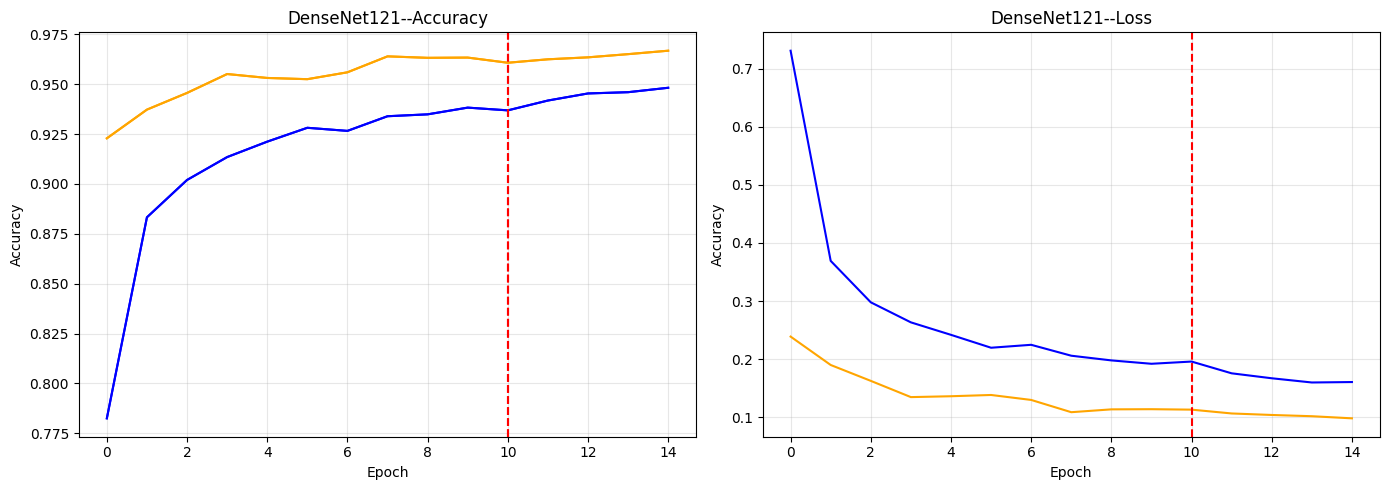

In [26]:
acc = history_p1.history['accuracy'] + history_p2.history['accuracy']
val_acc = history_p1.history['val_accuracy'] + history_p2.history['val_accuracy']
loss = history_p1.history['loss'] + history_p2.history['loss']
val_loss = history_p1.history['val_loss'] + history_p2.history['val_loss']
sep = len(history_p1.history['accuracy'])
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(acc, label='Train Accuracy', color='blue')
axes[0].plot(val_acc, label='Val Accuracy', color='orange')
axes[0].axvline(x=sep, color='red', linestyle='--',label='Debut Fine-Tuning')
axes[0].set_title('DenseNet121--Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True, alpha=0.3)

axes[0].plot(acc, label='Train Accuracy', color='blue')
axes[0].plot(val_acc, label='Val Accuracy', color='orange')
axes[0].axvline(x=sep, color='red', linestyle='--',label='Debut Fine-Tuning')
axes[0].set_title('DenseNet121--Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True, alpha=0.3)

axes[1].plot(loss, label='Train Loss', color='blue')
axes[1].plot(val_loss, label='Val Loss', color='orange')
axes[1].axvline(x=sep, color='red', linestyle='--',label='Debut Fine-Tuning')
axes[1].set_title('DenseNet121--Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluation

## Evaluation globale

In [27]:
test_loss, test_acc = model_121.evaluate(test_batches, verbose=1)
print(f"\nDenseNet121--Test Accuracy : {test_acc*100:.2f}%")
print(f"\nDenseNet121--Test Loss : {test_loss:.4f}%")

128/128 ━━━━━━━━━━━━━━━━━━━━ 71s 554ms/step - accuracy: 0.9711 - loss: 0.0798

DenseNet121--Test Accuracy : 96.23%

DenseNet121--Test Loss : 0.1089%


# Predictions sur le test set

> **IMPORTANT** : Ces probabilites sont sauvegardees pour le Soft Voting
!

In [28]:
print("\nCalcul des predictions...")
pred_proba = model_121.predict(test_batches, verbose=1)
pred_classes = np.argmax(pred_proba, axis=1)
y_true = test_batches.classes
class_names = list(test_batches.class_indices.keys())


Calcul des predictions...
128/128 ━━━━━━━━━━━━━━━━━━━━ 43s 255ms/step


## Rapport de classification

In [29]:
print("\nRapport de Classification :")
print(classification_report(y_true, pred_classes, target_names=class_names))


Rapport de Classification :
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.92      0.95        95
                                 Apple___Black_rot       1.00      1.00      1.00        94
                          Apple___Cedar_apple_rust       0.98      0.98      0.98        42
                                   Apple___healthy       0.95      1.00      0.97       248
                               Blueberry___healthy       1.00      0.99      0.99       226
          Cherry_(including_sour)___Powdery_mildew       1.00      0.97      0.99       159
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       129
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.74      0.94      0.82        78
                       Corn_(maize)___Common_rust_       0.96      0.99      0.98       180
               Corn_(maize)___Northern_Leaf_Blight

##  Confusion Matrix

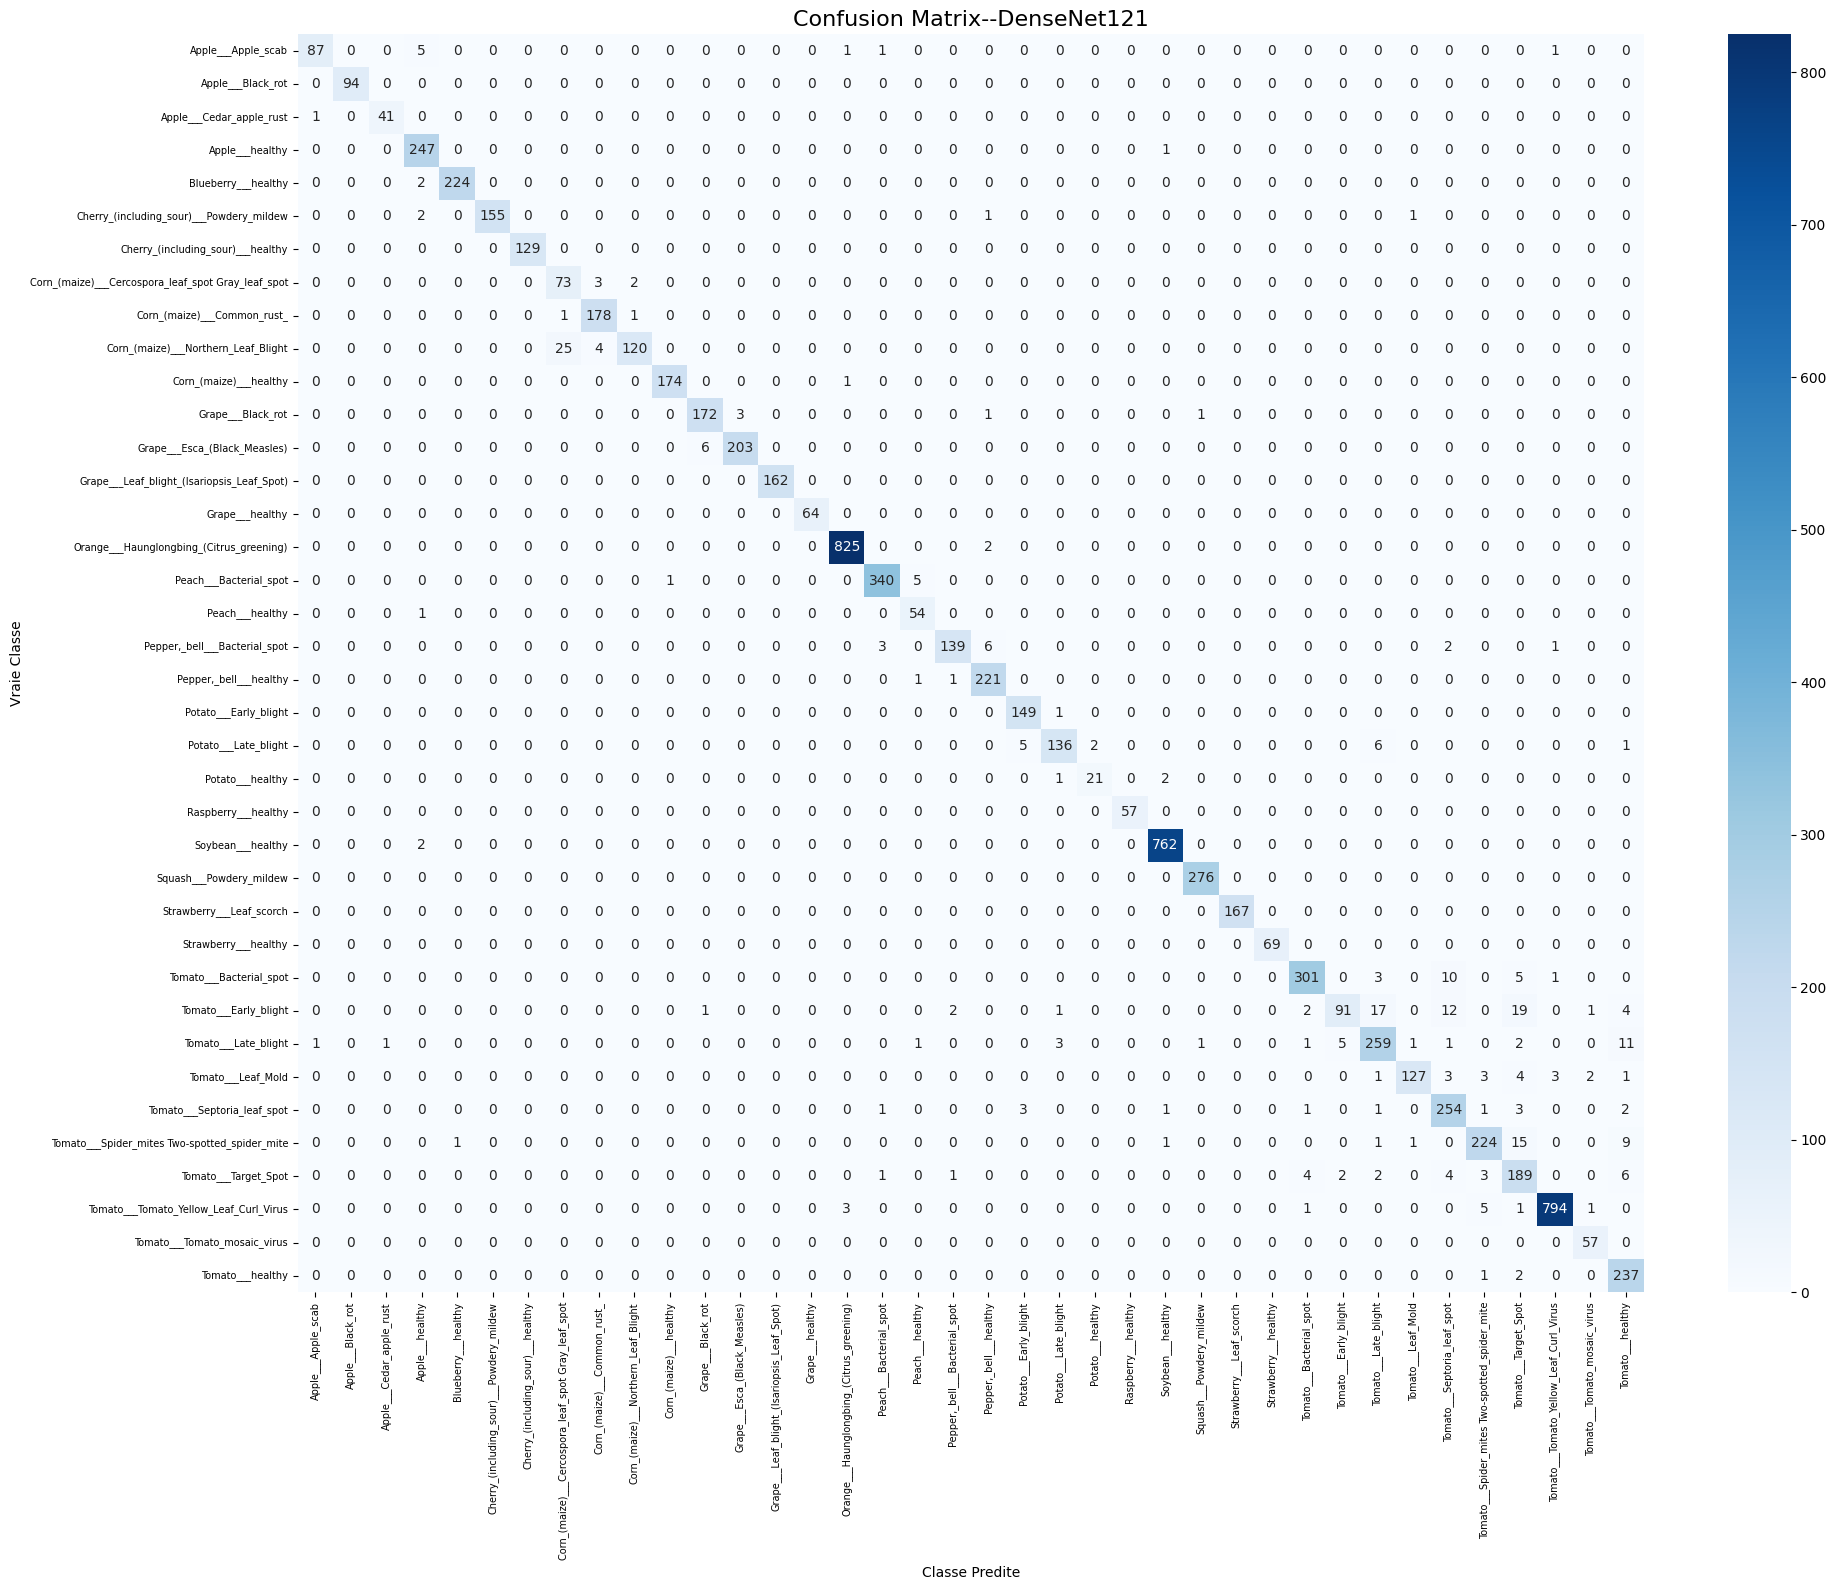

In [33]:
cm = confusion_matrix(y_true, pred_classes)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, fmt='d', annot=True, cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.title('Confusion Matrix--DenseNet121', fontsize=16)
plt.xlabel('Classe Predite')
plt.ylabel('Vraie Classe')
plt.xticks(rotation=90, fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.tight_layout()
plt.show()

# SAUVEGARDE DES PREDICTIONS (CRUCIAL pour le Soft Voting)

In [34]:
np.save('/kaggle/working/pred_densenet121.npy', pred_proba)
print("\nPredictions sauvegardees : pred_densenet121.npy")
print(f"Shape : {pred_proba.shape}")


Predictions sauvegardees : pred_densenet121.npy
Shape : (8180, 38)


## Sauvegarder aussi le modele

In [35]:
model_121.save('densenet121_final.h5')
print("Modele sauvegarde : densenet121_final.h5")

Modele sauvegarde : densenet121_final.h5


In [36]:
import os
print(os.listdir('/kaggle/working/'))

['pred_densenet121.npy', '.virtual_documents', 'densenet121_final.h5', 'densenet121_best.h5']
